# Notebook 6: Data Exploration
---

In [1]:
import calendar
import datetime as dt
import numpy as np
import pandas as pd

import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="white", rc=custom_params)
sns.set_palette('pastel')
colors = sns.color_palette()

from matplotlib import gridspec
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.rcParams['figure.figsize'] = [16,5]
plt.rcParams['figure.facecolor'] = 'cornsilk'
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 12
plt.rcParams['axes.labelpad'] = 10

import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis, gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet('../clean_data/engineered_data.parquet')

In [3]:
df.describe().round(2)

nyc_trips_casual  nyc_trips_member  brooklyn_start_all  \
count          43824.00          43824.00            43824.00   
mean             409.50           1666.02              511.17   
std              471.81           1423.28              460.27   
min                8.00             60.00               17.00   
25%               58.00            376.00              113.00   
50%              212.00           1350.00              382.00   
75%              595.00           2613.00              803.00   
max             1668.00           4776.85             1578.00   

       manhattan_start_all  queens_start_all  brooklyn_end_all  \
count             43824.00          43824.00          43824.00   
mean               1459.52            116.50            512.08   
std                1281.62            110.05            464.77   
min                  52.00              3.00             17.00   
25%                 327.00             25.00            114.00   
50%                1137.00             81.00            378.00   
75%                2266.00            179.00            793.25   
max                4349.00            374.00           1603.00   

       manhattan_end_all  queens_end_all  nyc_trips_all  \
count           43824.00        43824.00       43824.00   
mean             1459.32          116.17        2088.87   
std              1282.39          107.58        1841.62   
min                52.00            3.00          74.00   
25%               322.00           26.00         467.00   
50%              1134.00           81.00        1609.00   
75%              2268.00          179.00        3256.00   
max              4336.00          367.00        6250.85   

       brooklyn_start_casual  ...  visibility  isPaidTimeOff  isHoliday  \
count               43824.00  ...    43824.00       43824.00   43824.00   
mean                  121.56  ...        9.52           0.03       0.03   
std                   141.17  ...        1.13           0.16       0.17   
min                     2.00  ...        5.40           0.00       0.00   
25%                    16.00  ...        9.90           0.00       0.00   
50%                    62.00  ...        9.90           0.00       0.00   
75%                   178.00  ...        9.90           0.00       0.00   
max                   498.00  ...        9.90           1.00       1.00   

       nyc_bike_counts      hour  weekday     month      year   weekend  \
count         43824.00  43824.00  43824.0  43824.00  43824.00  43824.00   
mean           1528.84     11.50      3.0      6.52   2020.41      0.29   
std            1191.39      6.92      2.0      3.45      1.50      0.45   
min              92.00      0.00      0.0      1.00   2018.00      0.00   
25%             460.75      5.75      1.0      4.00   2019.00      0.00   
50%            1296.00     11.50      3.0      7.00   2020.00      0.00   
75%            2357.25     17.25      5.0     10.00   2022.00      1.00   
max            4085.00     23.00      6.0     12.00   2023.00      1.00   

       bike_counts_log  
count         43824.00  
mean              2.98  
std               0.49  
min               1.96  
25%               2.66  
50%               3.11  
75%               3.37  
max               3.61  

[8 rows x 35 columns]

In [4]:
boroughs = ['brooklyn', 'manhattan', 'queens']
borough_labels = [b.capitalize() for b in boroughs]
seasons = ['winter', 'spring', 'summer', 'autumn']
months = [month.capitalize() for month in calendar.month_name[1:]][::-1]
weekdays=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', 
         '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'][::-1]
pandemic_order = ['pre-pandemic', 'lockdown', 'reopening', 'post-vaccine', 'post-pandemic']
rider_labels = ['All', 'Casual', 'Member']
rider_title = 'Rider Type'

---
## Visualize Citi Bike ridership trends over time, including hourly ride counts.
---

In [5]:
def get_scale(value):
    """
    Determines the scale category of a given numerical value.

    Parameters:
        value (numeric): The value for which the scale category is to be determined.

    Returns:
        str: The scale category of the value, such as 'units', 'thousands', 'millions',
             'billions', or 'trillions'.

    Examples:
        >>> get_scale(5000)
        'thousands'
        >>> get_scale(1000000)
        'millions'
        >>> get_scale(2.5e12)
        'trillions'
    """
    # Calculate the logarithm base 10 of the absolute value of the number
    scale = np.log10(abs(value))

    # Determine the scale category based on the logarithm value
    if scale < 3:
        return 'units'
    elif scale < 6:
        return 'thousands'
    elif scale < 9:
        return 'millions'
    elif scale < 12:
        return 'billions'
    else:
        return 'trillions'

In [6]:
def plot_temporal_period(df, borough, span_num, span_name, axis):
    """
    Plots the temporal distribution of bike trips for a specific borough and time span.

    Parameters:
        df (DataFrame): The DataFrame containing the bike trip data.
        borough (str): The borough for which the data should be plotted ('NYC', 'brooklyn', 'manhattan', 'queens').
        span_num (int): The number of days for the rolling sum calculation.
        span_name (str): The name of the time span (e.g., 'yearly', 'monthly', 'weekly').
        axis: The axis on which to plot the data.

    Returns:
        None

    Examples:
        >>> plot_temporal_period(df, 'NYC', 365, 'yearly', ax)
    """
    # Compute the rolling sum of trip data for the specified borough and span
    if borough == 'NYC':
        df_rolling = df[['nyc_trips_all', 'nyc_trips_casual', 'nyc_trips_member']
                       ].rolling(f'{span_num}D').sum()[(24*span_num+1):]
    else:
        df_rolling = df[[f'{borough}_start_all', f'{borough}_start_casual', f'{borough}_start_member']
                       ].rolling(f'{span_num}D').sum()[(24*span_num+1):]

    # Plot trip totals
    ax = sns.lineplot(data=df_rolling, ax=axis)

    # Shade pandemic phases
    for i, period in enumerate(df['pandemic_period'].unique()):
        start = df[df['pandemic_period'] == period].index.min()

        if start < df_rolling.index.min():
            start = df_rolling.index.min()

        end = df[df['pandemic_period'] == period].index.max()

        ax.fill_betweenx((0, df_rolling.max().max()), start, end, color=colors[i+3], alpha=0.15)

    # Add a legend for the specific case of yearly rolling period
    if span_num == 365:
        # Create legend handles
        blank = mpatches.Patch(color='white', label='')
        ht1 = mpatches.Patch(color='white', label='Rider Type')
        h1 = mpatches.Patch(color=colors[0], label='All')
        h2 = mpatches.Patch(color=colors[1], label='Casual')
        h3 = mpatches.Patch(color=colors[2], label='Members')

        ht2 = mpatches.Patch(color='white', label='Pandemic Period')
        h4 = mpatches.Patch(color=colors[3], label='Pre-Pandemic')
        h5 = mpatches.Patch(color=colors[4], label='Early Pandemic')
        h6 = mpatches.Patch(color=colors[5], label='Lockdown')
        h7 = mpatches.Patch(color=colors[6], label='Reopening')
        h8 = mpatches.Patch(color=colors[7], label='Post-Vaccine')
        h9 = mpatches.Patch(color=colors[8], label='Post-Pandemic')

        # Add the legend
        legend = ax.legend(handles=[blank, ht1, h1, h2, h3, blank, ht2, h4, h5, h6, h7, h8, h9, blank], 
                           bbox_to_anchor=[1, 1.02])
        
        # Get the individual Text objects within the legend
        texts = legend.get_texts()

        # Set the font weight for specific handles
        texts[1].set_fontweight('bold')
        texts[6].set_fontweight('bold')
    else:
        ax.legend().remove()

    # Add plot labels
    ax.set_title(f'{span_name}ly (rolling {span_num} days)')
    ax.set_xlabel(None)
    scale = get_scale(df_rolling.max().max())
    if scale == 'millions':
        ax.set_ylabel(f'Number of Bike Trips\n({scale})', labelpad=31)
    else:
        ax.set_ylabel(f'Number of Bike Trips\n({scale})')

In [7]:
def plot_temporal_data(df, borough):
    """
    Plots the temporal ridership trends for a specific borough.

    Parameters:
        df (DataFrame): The DataFrame containing the bike trip data.
        borough (str): The borough for which the data should be plotted ('NYC', 'brooklyn', 'manhattan', 'queens').

    Returns:
        None

    Examples:
        >>> plot_temporal_data(df, 'manhattan')
    """
    # Create a figure with subplots
    fig, ax = plt.subplots(3, 1, figsize=(16, 15))
    
    # Set the title
    if borough == 'NYC':
        fig.text(0.3755, 1, f'{borough} Citi Bike Ridership Trends', fontsize=17, fontweight='bold')
    else:
        fig.text(0.3755, 1, f'{borough.capitalize()} Citi Bike Ridership Trends', fontsize=17, fontweight='bold')

    # Iterate over each time period
    for i, (span_num, span_name) in enumerate([(365, 'Year'), (28, 'Month'), (7, 'Week')]):
        ax[i] = plot_temporal_period(df, borough, span_num, span_name, ax[i])
        plt.tight_layout(pad=3)
    
    # Show the plots
    plt.show()

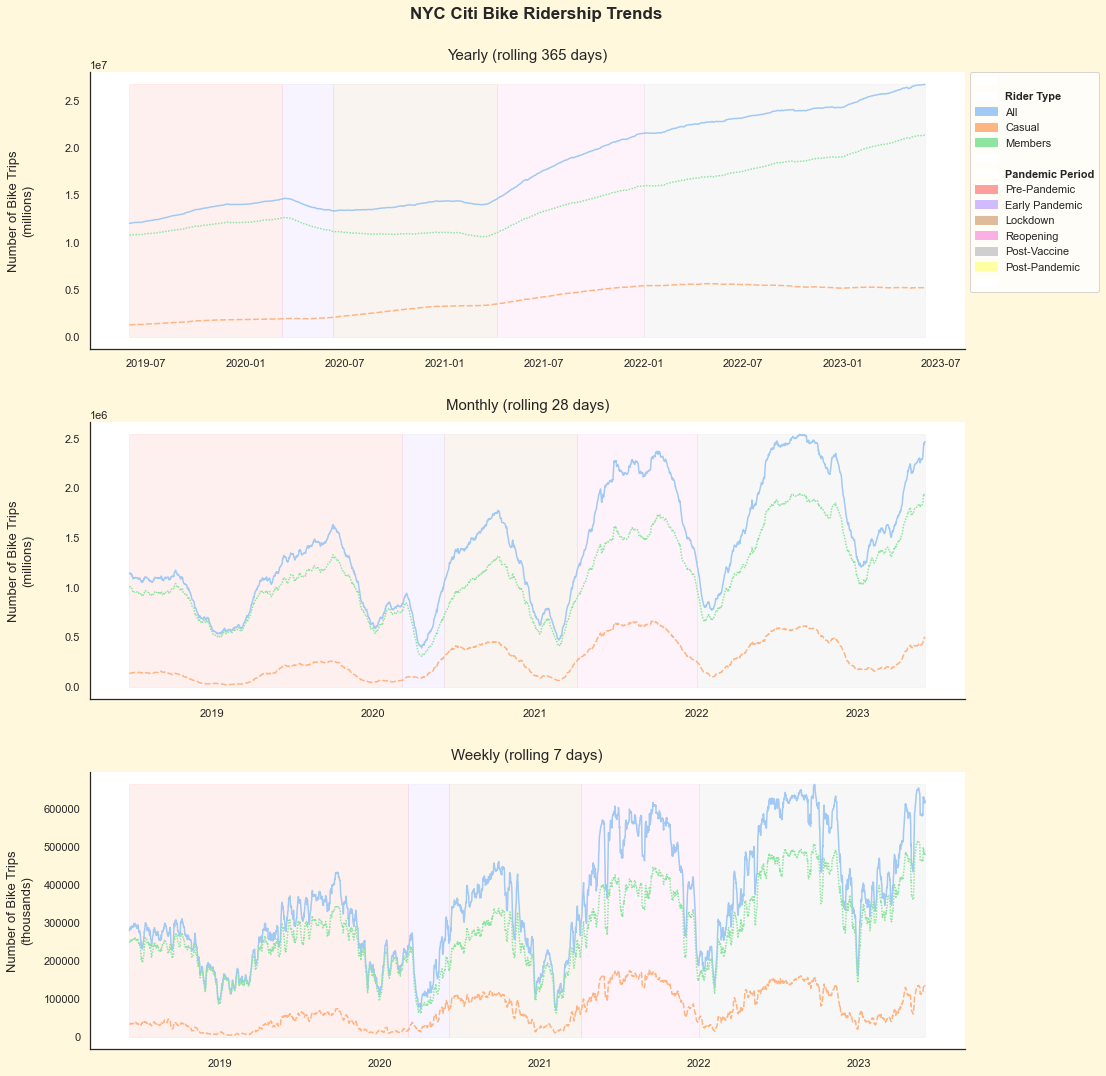

In [8]:
plot_temporal_data(df, 'NYC')

In [9]:
def label_bars(ax, label_shift, orient='v', stacked=False):
    """
    Labels the bars in a bar plot with their corresponding values.

    Parameters:
        ax (Axes): The matplotlib Axes object representing the bar plot.
        label_shift (float): The shift distance of the labels from the bars.
        orient (str, optional): The orientation of the bars ('v' for vertical, 'h' for horizontal). Default is 'v'.
        stacked (bool, optional): Indicates if the bars are stacked. Default is False.

    Returns:
        None
    """
    for i, container in enumerate(ax.containers):
        for bar in container:
            if orient == 'h':
                # Get the label value
                width = bar.get_width()

                # Get the bar location
                y = bar.get_y() + bar.get_height() / 2

                # Adjust the label height
                if stacked:
                    if i == 0:
                        x = width + label_shift
                    else:
                        x = 95
                else:
                    x = width + label_shift

                # Set the bar label
                ax.annotate(f'{width:,.0f}%', (x, y), ha='center', va='center', fontsize=11.5)
            else:
                # Get the label value
                height = bar.get_height()

                # Get the bar location
                x = bar.get_x() + bar.get_width() / 2

                # Adjust the label height
                if stacked:
                    if i == 0:
                        y = height + label_shift
                    else:
                        y = 95
                else:
                    y = height + label_shift

                # Set the bar label
                ax.annotate(f'{height:,.0f}%', (x, y), ha='center', va='center', fontsize=11.5)

In [10]:
def get_distro(df, borough, groupby_col, index):
    """
    Calculates the percentage distribution of a specific column in a DataFrame based on a given grouping column.
    Also calculates the percentage distribution of ridership based on the rider type.

    Args:
        df (DataFrame): Input DataFrame containing the data.
        borough (str): The borough to select the data from.
        groupby_col (str): The column to group the data by.
        index (list or array-like): The desired index order for the resulting distributions.

    Returns:
        tuple: A tuple containing two objects:
               - A Series representing the percentage distribution of the specified column.
                 The index represents the categories based on the groupby column.
               - A DataFrame representing the percentage distribution of ridership.
                 The index represents the categories (rider labels) and the columns represent the groupby categories.

    """
    # Group the DataFrame by the specified column and calculate the sum
    data = df.groupby(groupby_col).sum().reindex(index)

    # Extract the column representing the total trips and trips by rider type
    if borough == 'nyc':
        all_riders = data[f'{borough}_trips_all']
        select_riders = data[[f'{borough}_trips_casual', f'{borough}_trips_member']]
    else:
        all_riders = data[f'{borough}_start_all']
        select_riders = data[[f'{borough}_start_casual', f'{borough}_start_member']]
    
    # Calculate the percentage distribution of the period
    temporal_distro = (all_riders / sum(all_riders) * 100)
    
    # Calculate the percentage distribution of ridership
    rider_distro = pd.DataFrame((select_riders[col] / all_riders * 100 for col in select_riders.columns), 
                                index=rider_labels[1:]).transpose()

    # Return the percentage distributions as a tuple
    return temporal_distro, rider_distro

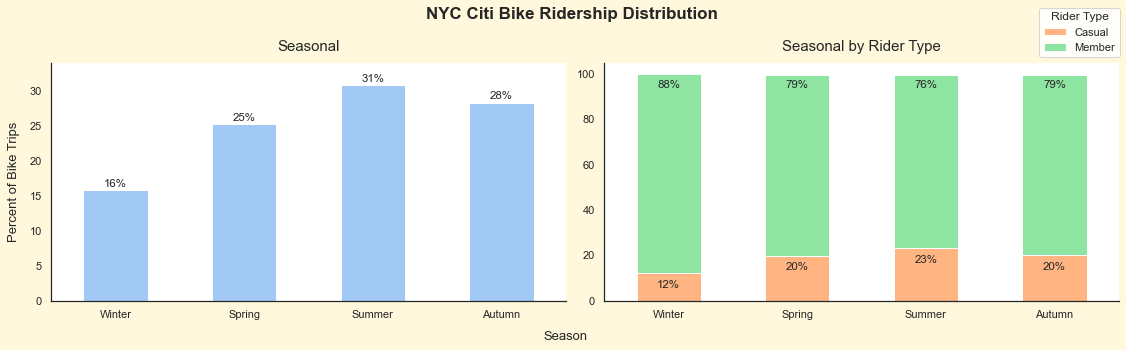

In [11]:
# Set up the figure
fig, ax = plt.subplots(1,2, figsize=(16,5))

# Compile the seasonal distribution of trips
temporal, rider = get_distro(df, 'nyc', 'season', seasons)
ax1 = temporal.plot(kind='bar', ax=ax[0])

# Add labels
ax1.set_title('Seasonal')
ax1.set_xlabel(None)
ax1.set_ylabel('Percent of Bike Trips')
ax1.set_xticks(range(len(seasons)), [s.capitalize() for s in seasons], rotation=0)
ax1.set_ylim(0, 34)
label_bars(ax1, 1)

# Plot the seasonal distribution by rider type
ax2 = rider.plot(kind='bar', stacked=True, ax=ax[1], color=colors[1:3])

# Add labels
ax2.legend(title=rider_title, bbox_to_anchor=[0.835, 1])
ax2.set_title('Seasonal by Rider Type')
ax2.set_xlabel(None)
ax2.set_xticks(range(len(seasons)), [s.capitalize() for s in seasons], rotation=0)
label_bars(ax2, -5, stacked=True)

# Set figure level labels
fig.suptitle('NYC Citi Bike Ridership Distribution', y=0.9, fontsize=17, fontweight='bold')
fig.text(0.475, -0.025, 'Season', fontsize=13)
plt.tight_layout()
plt.show()

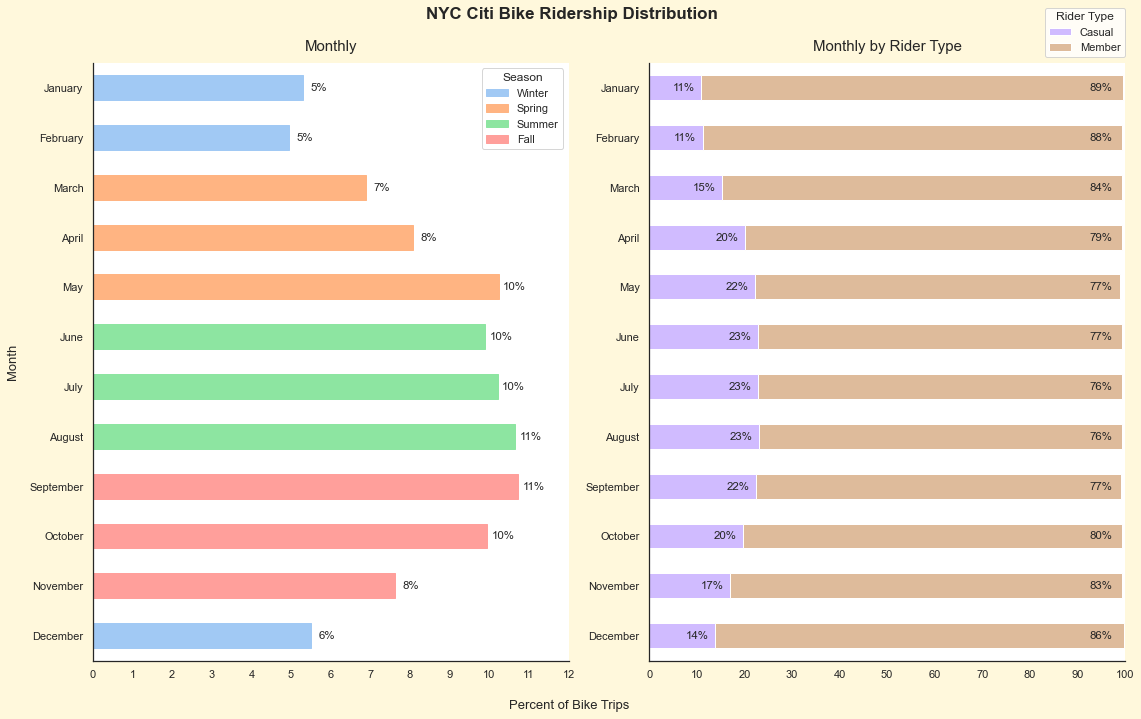

In [12]:
# Set up the figure
fig, ax = plt.subplots(1,2, figsize=(16, 10))

# Compile the monthly distribution of trips
month_index = range(12, 0, -1)
temporal, rider = get_distro(df, 'nyc', 'month', month_index)
ax1 = temporal.plot(kind='barh', ax=ax[0])

# Add labels
ax1.set_title('Monthly')
ax1.set_xlabel(None)
ax1.set_ylabel('Month')
ax1.set_yticks(range(12), months)
ax1.set_xticks(range(0, 13))
label_bars(ax1, 0.4, orient='h')
        
# Differentiate seasons by color
ax1.get_children()[0].set_color(colors[0])
[ax1.get_children()[i].set_color(colors[0]) for i in range(10, 12)]
[ax1.get_children()[i].set_color(colors[1]) for i in range(7, 10)]
[ax1.get_children()[i].set_color(colors[2]) for i in range(4, 7)]
[ax1.get_children()[i].set_color(colors[3]) for i in range(1, 4)]

# Create legend handles
h1 = mpatches.Patch(color=colors[0], label='Winter')
h2 = mpatches.Patch(color=colors[1], label='Spring')
h3 = mpatches.Patch(color=colors[2], label='Summer')
h4 = mpatches.Patch(color=colors[3], label='Fall')

# Add a legend
ax1.legend(handles = [h1, h2, h3, h4], title='Season')

# Compile and plot the distribution by rider type
ax2 = rider.plot(kind='barh', stacked=True, ax=ax[1], color=colors[4:7])

# Add labels
ax2.legend(labels=rider_labels[1:], title=rider_title, bbox_to_anchor=[0.82, 1])
ax2.set_title('Monthly by Rider Type')
ax2.set_ylabel(None)
ax2.set_yticks(range(12), months)
ax2.set_xlim(0, 100)
ax2.set_xticks(range(0, 101, 10))
label_bars(ax2, -3.75, orient='h', stacked=True)

plt.suptitle('NYC Citi Bike Ridership Distribution', y=0.95, fontsize=17, fontweight='bold')
fig.text(0.445, -0.025, 'Percent of Bike Trips', fontsize=13)
plt.tight_layout()
plt.show()

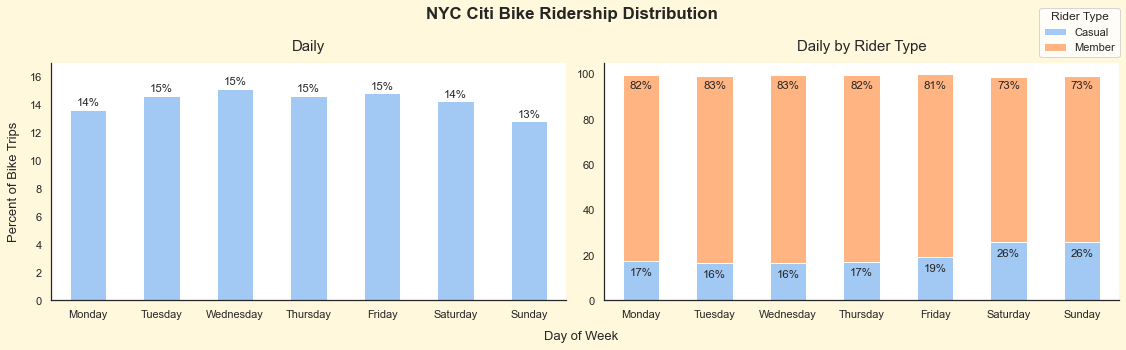

In [13]:
# Set up the figure
fig, ax = plt.subplots(1, 2)

# Compile the seasonal distribution of trips
temporal, rider = get_distro(df, 'nyc', 'weekday', range(7))
ax1 = temporal.plot(kind='bar', ax=ax[0])

# Add labels
ax1.set_title('Daily')
ax1.set_xlabel(None)
ax1.set_ylabel('Percent of Bike Trips')
ax1.set_xticks(range(len(weekdays)), weekdays, rotation=0)
ax1.set_ylim(0, 17)
label_bars(ax1, 0.5)

# Compile and plot the seasonal distribution by rider type
ax2 = rider.plot(kind='bar', stacked=True, ax=ax[1])

# Add labels
ax2.legend(labels=rider_labels[1:], title=rider_title, bbox_to_anchor=(0.835, 1))
ax2.set_title('Daily by Rider Type')
ax2.set_xlabel(None)
ax2.set_xticks(range(len(weekdays)), weekdays, rotation=0)
label_bars(ax2, -5, stacked=True)

fig.suptitle('NYC Citi Bike Ridership Distribution', y=0.9, fontsize=17, fontweight='bold')
fig.text(0.475, -0.025, 'Day of Week', fontsize=13)
plt.tight_layout()
plt.show()

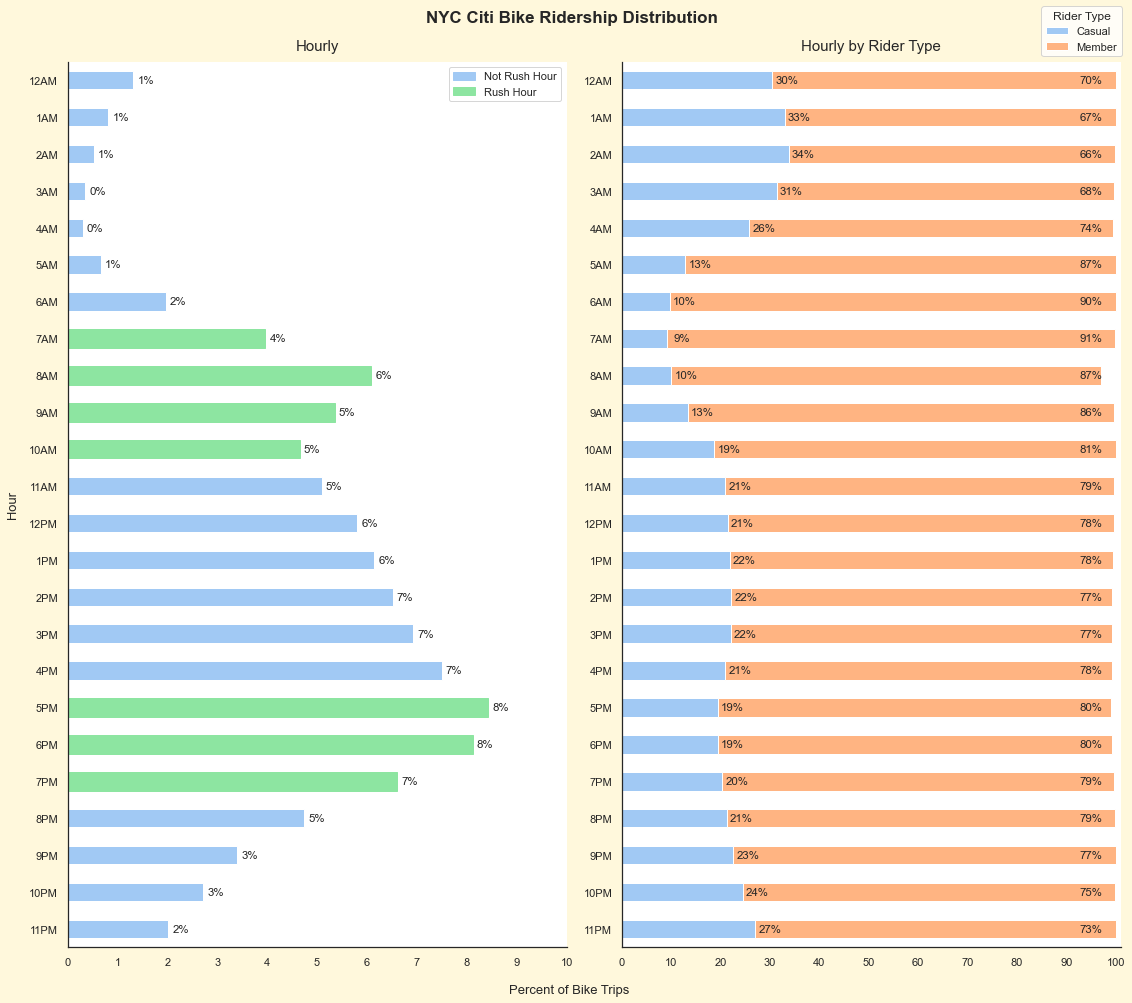

In [14]:
# Set up the figure
fig, ax = plt.subplots(1,2, figsize=(16,14))

# Compile the distribution of trips
hour_index = range(23, -1, -1)
temporal, rider = get_distro(df, 'nyc', 'hour', hour_index)
ax1 = temporal.plot(kind='barh', ax=ax[0])

# Add labels
ax1.set_title('Hourly')
ax1.set_xlabel(None)
ax1.set_xticks(range(11))
ax1.set_ylabel('Hour')
ax1.set_yticks(range(24), hours)
label_bars(ax1, 0.25, orient='h')

# Differentiate rush-hour by color
[ax1.get_children()[i].set_color(colors[2]) for i in range(13, 17)]
[ax1.get_children()[i].set_color(colors[2]) for i in range(4, 7)]

# Create legend handles
h1 = mpatches.Patch(color=colors[0], label='Not Rush Hour')
h2 = mpatches.Patch(color=colors[2], label='Rush Hour')

# Add a legend
ax1.legend(handles=[h1, h2])
        
# Compile and plot the distribution by rider type
ax2 = rider.plot(kind='barh', stacked=True, ax=ax[1])

# Add labels
ax2.set_title('Hourly by Rider Type')
ax2.set_xticks(range(0, 101, 10))
ax2.set_xlim(0, 101)
ax2.set_ylabel(None)
ax2.set_yticks(range(24), hours)
ax2.legend(labels=rider_labels[1:], title=rider_title, bbox_to_anchor=[0.83, 1])
label_bars(ax2, 3, orient='h', stacked=True)

fig.suptitle('NYC Citi Bike Ridership Distribution', y=0.96, fontsize=17, fontweight='bold')
fig.text(0.445, -0.015, 'Percent of Bike Trips', fontsize=13)
plt.tight_layout()
plt.show()

In [15]:
# Group the data by day type and hour
data = df.groupby(['weekend', 'hour']).sum().reset_index()[['weekend', 'hour', 'nyc_trips_all']]

In [16]:
# Seperate the data by day type
weekday = data[data['weekend'] == 0]
weekend = data[data['weekend'] == 1].reset_index(drop=True)

In [17]:
# Group the data by hour
data = df.groupby('hour').sum()['nyc_trips_all']

In [18]:
# Calculate the percentage of rides for each day type
weekday['nyc_trips_all'] = (weekday['nyc_trips_all']/data)*100
weekend['nyc_trips_all'] = (weekend['nyc_trips_all']/data)*100

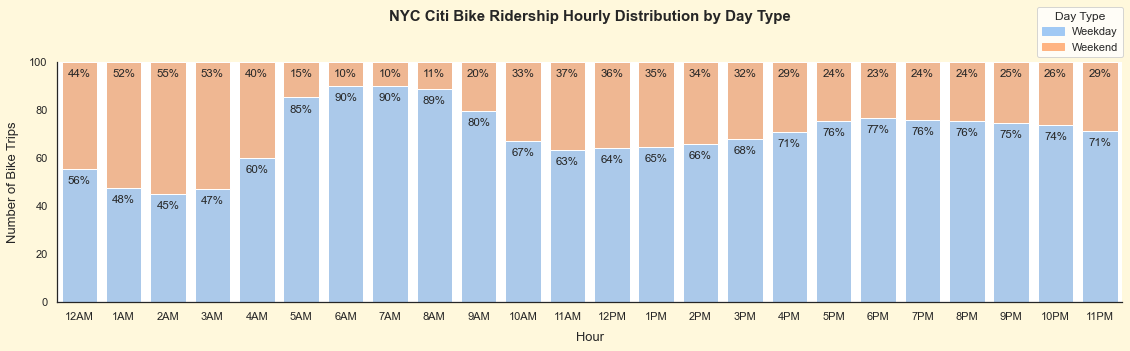

In [19]:
ax = sns.barplot(data=weekday, x='hour', y='nyc_trips_all', color=colors[0])
sns.barplot(data=weekend, x='hour', y='nyc_trips_all', bottom=weekday['nyc_trips_all'], color=colors[1])
ax.set_xticks(range(24), hours[::-1])
ax.set_xlabel('Hour')
ax.set_ylabel('Number of Bike Trips')
ax.set_title('NYC Citi Bike Ridership Hourly Distribution by Day Type', y=1.125, fontweight='bold')
ax.set_ylim(0, 100)
label_bars(ax, -5, stacked=True)
        
# Create legend handles
h1 = mpatches.Patch(color=colors[0], label='Weekday')
h2 = mpatches.Patch(color=colors[1], label='Weekend')

ax.legend(handles=[h1, h2], title='Day Type', bbox_to_anchor=[0.915, 1])

plt.tight_layout()
plt.show()

---
## Explore the relationship between ridership and weather conditions through scatter plots or correlation analysis.
---

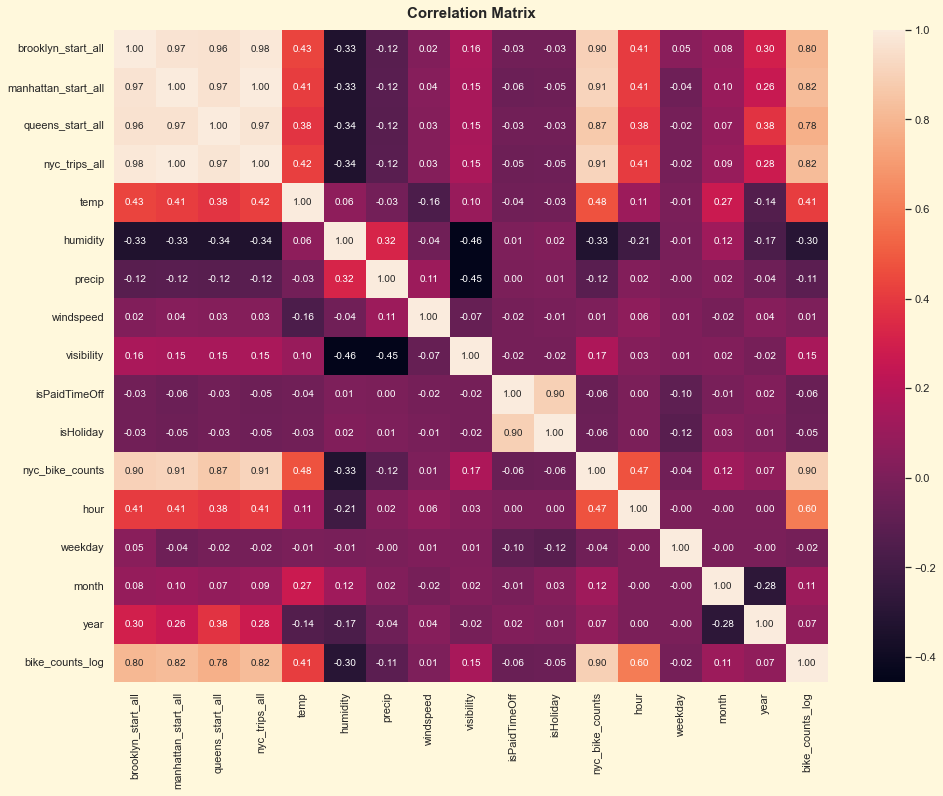

In [20]:
plt.figure(figsize=(16,12))

# Plot the correlation matrix
sns.heatmap(data=df[
    [col for col in df.columns if 'end' not in col and 'casual' not in col and 'member' not in col]
].corr(), annot=True, fmt='.2f')

plt.title('Correlation Matrix', fontweight='bold')
plt.show()

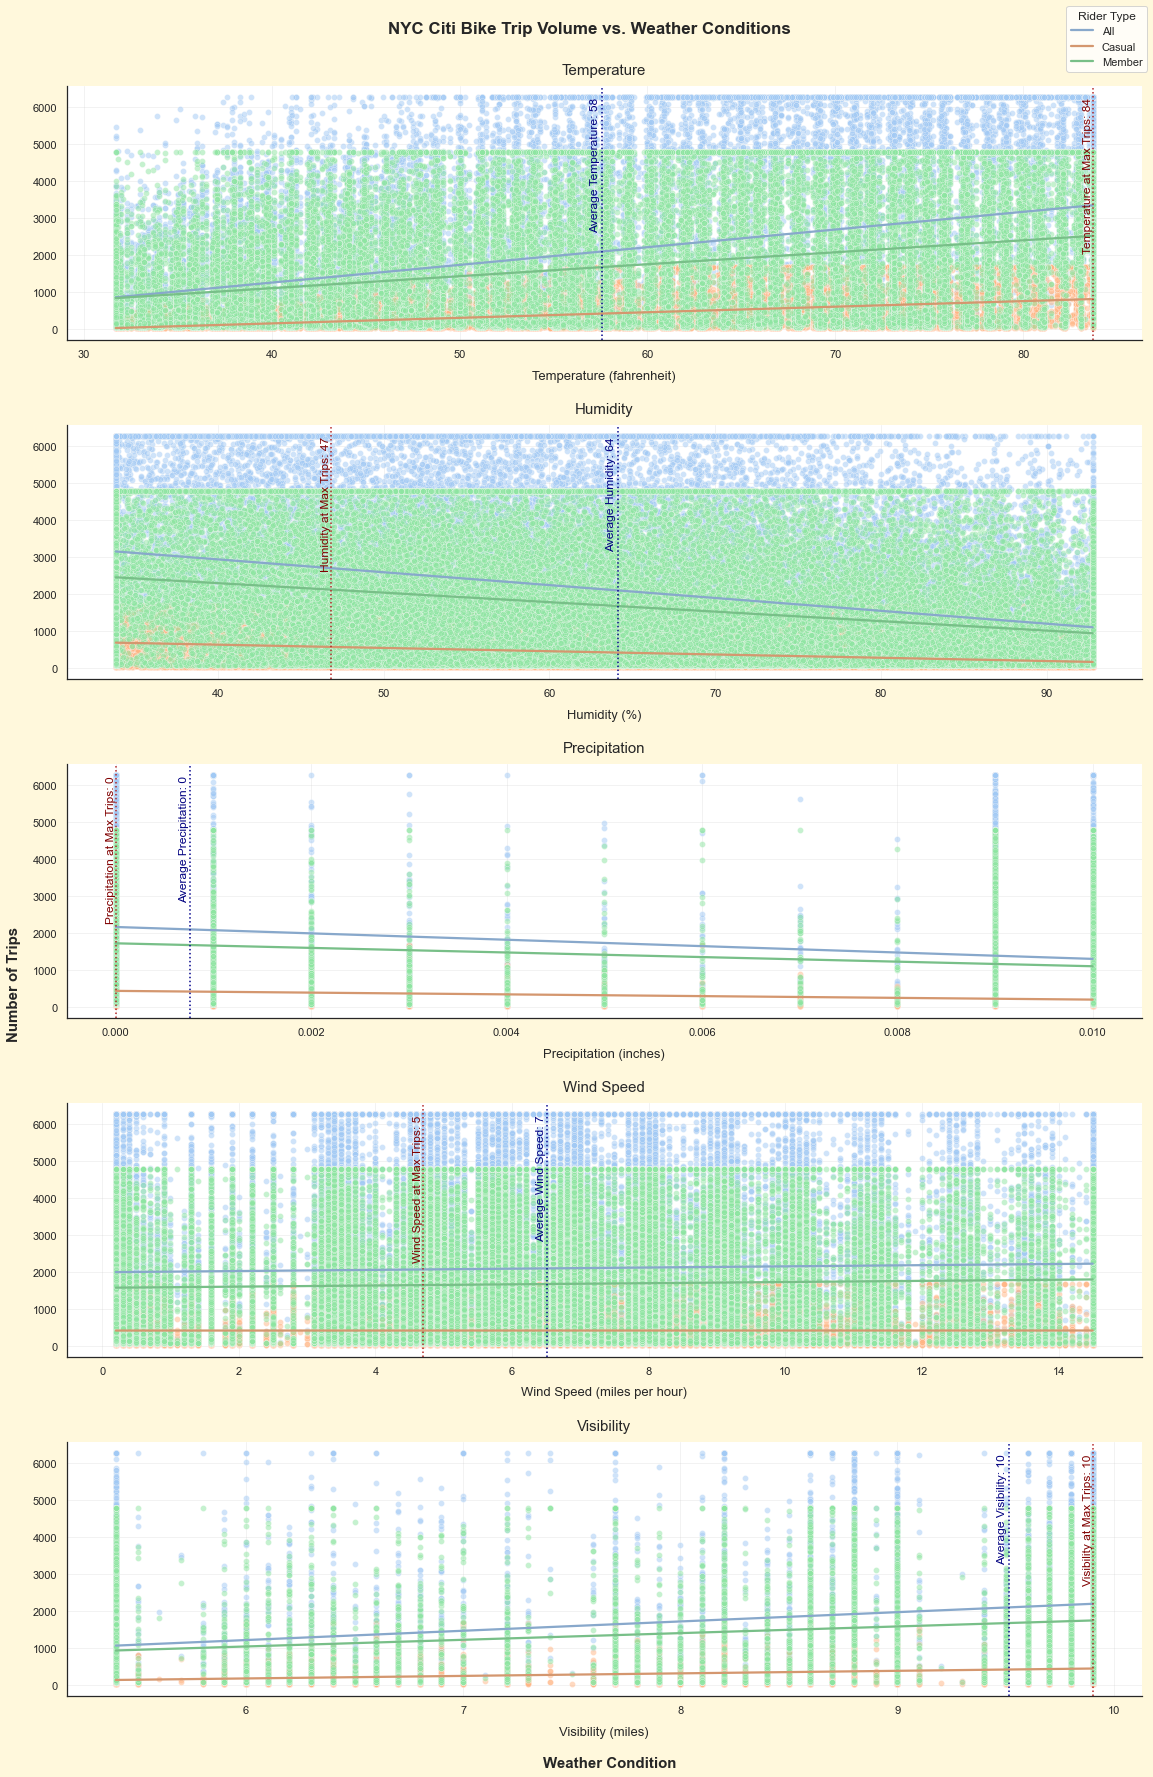

In [21]:
# Create a dictionary for weather condition units
var_dict = {'temp': ['Temperature', 'fahrenheit'], 'humidity': ['Humidity', '%'], 
            'precip': ['Precipitation', 'inches'], 'windspeed': ['Wind Speed', 'miles per hour'], 
            'visibility': ['Visibility', 'miles']}

# Set up the figure
fig, ax = plt.subplots(len(var_dict), 1, figsize=(16, len(var_dict) * 5))

# Plot the variables in the dictionary
for n, (var, var_labels) in enumerate(var_dict.items()):
    # Unpack the labels and units
    label, unit = var_labels
    
    # Plot each column
    for i, col in enumerate(['nyc_trips_all', 'nyc_trips_casual', 'nyc_trips_member']):
        sns.scatterplot(data=df, x=var, y=col, alpha=0.5, ax=ax[n])
        sns.regplot(data=df, x=var, y=col, scatter=False, ci=None, label=rider_labels[i],
                    color=sns.dark_palette(colors[i], reverse=True)[1], ax=ax[n])

    # Add labels and title
    ax[n].set_title(label)
    ax[n].set_xlabel(f'{label} ({unit})')
    ax[n].set_ylabel(None)
    ax[n].grid(alpha=0.25)
        
    if n == 0:
        ax[n].legend(title='Rider Type', bbox_to_anchor=[1.01, 1.335])
    else:
        ax[n].legend().remove()
        
    # Find the maximum y-value and its corresponding x-value
    max_y = df['nyc_trips_all'].max()
    max_x = df.loc[df['nyc_trips_all'].idxmax(), var]
    mean_x = df[var].mean()
    
    # Add a vertical line at the maximum y-value
    ax[n].axvline(x=max_x, color='firebrick', linestyle=':')
    
    # Add a label for the vertical line
    ax[n].text(max_x, max_y, f'{label} at Max Trips: {max_x:.0f}', color='maroon', 
                            ha='right', va='top', rotation=90, fontsize=12)
    
    # Add a vertical line at the mean x-value
    ax[n].axvline(x=mean_x, color='darkblue', linestyle=':')
    
    # Map the factor for each variable
    label_x_mapping = {'temp': 0.485, 'humidity': 0.502, 'precip': 0.065, 'windspeed': 0.43, 'visibility': 0.902}
    
    # Adjust the position of the label based on the range of x-values for the subplot
    x_range = df[var].max() - df[var].min()
    label_x_mean = df[var].min() + x_range * label_x_mapping.get(var)
    
    # Add a label for the vertical line
    ax[n].text(label_x_mean, max_y, f'Average {label}: {mean_x:.0f}', color='navy', 
                            ha='left', va='top', rotation=90, fontsize=12)

# Add figure labels and titles
fig.suptitle(f'NYC Citi Bike Trip Volume vs. Weather Conditions', y=0.965, fontsize=17, fontweight='bold')
fig.text(0.46, -0.005, 'Weather Condition', fontsize=15, fontweight='bold')
fig.text(-0.005, 0.4, 'Number of Trips', fontsize=15, fontweight='bold', rotation=90)
plt.tight_layout(pad=2)
plt.show()

In [22]:
def calc_change(df, var):
    """
    Calculate and print the change in the number of rides for different ride types
    based on a predictor variable.

    Args:
        df (pd.DataFrame): DataFrame containing relevant data columns.
        var (str): The name of the predictor variable.

    Prints:
        Prints the change in number of rides per increase in the predictor variable for each ride type.
    """
    X = df[var]  # Predictor variable (temperature)
    X = sm.add_constant(X)  # Add constant term
    
    print(var_dict[var][0])
    for col in ['nyc_trips_all', 'nyc_trips_casual', 'nyc_trips_member']:
        y = df[col]  # Outcome variable (number of rides)
        model = sm.OLS(y, X).fit() # Fit linear regression model
        coef = model.params[var] # Get coefficient for temperature variable
        print(f"Change in {col.split('_')[-1:][0]} rides per increase in {var_dict[var][0].lower()}: {coef:.2f}")

In [23]:
for col in ['temp','humidity', 'precip', 'windspeed', 'visibility']:
    calc_change(df, col)
    if col != 'visibility':
        print()

Temperature
Change in all rides per increase in temperature: 47.82
Change in casual rides per increase in temperature: 15.06
Change in member rides per increase in temperature: 32.35

Humidity
Change in all rides per increase in humidity: -34.75
Change in casual rides per increase in humidity: -8.83
Change in member rides per increase in humidity: -25.65

Precipitation
Change in all rides per increase in precipitation: -86222.43
Change in casual rides per increase in precipitation: -23574.79
Change in member rides per increase in precipitation: -61985.67

Wind Speed
Change in all rides per increase in wind speed: 15.89
Change in casual rides per increase in wind speed: 0.09
Change in member rides per increase in wind speed: 15.57

Visibility
Change in all rides per increase in visibility: 251.19
Change in casual rides per increase in visibility: 68.71
Change in member rides per increase in visibility: 180.30


---
## Investigate spatial factors by analyzing ridership patterns across different boroughs or regions.
---

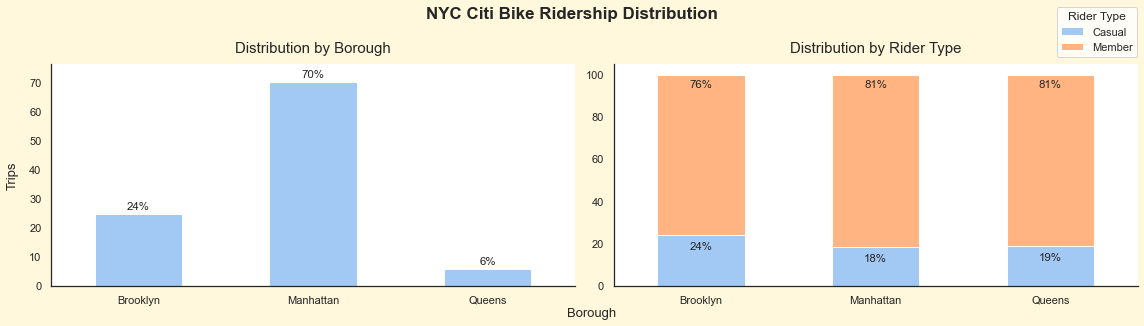

In [24]:
# Set up the figure
fig, ax = plt.subplots(1, 2)

# Calculate the percentage of rides per borough
data = df[[col for col in df.columns if 'all' in col and 'start' in col]].sum() / sum(df['nyc_trips_all']) * 100

# Plot the data
ax1 = data.plot(kind='bar', ax=ax[0])

# Set the labels and title
ax1.set_ylabel('Trips')
ax1.set_title('Distribution by Borough')
ax1.set_xticks(range(len(borough_labels)), borough_labels, rotation=0)
ax1.set_ylim(0, 76)
ax1.legend().remove()
label_bars(ax1, 3)
        
# Calculate the rider distibution for each borough
data = pd.DataFrame(index=boroughs, columns=['casual', 'member'])
for borough in boroughs:
    data.loc[borough, 'casual'] = sum(df[f"{borough}_start_casual"]) / sum(df[f"{borough}_start_all"]) * 100
    data.loc[borough, 'member'] = sum(df[f"{borough}_start_member"]) / sum(df[f"{borough}_start_all"]) * 100
            
# Plot the stacked bars
ax2 = data.plot(kind='bar', stacked=True, ax=ax[1])

# Add plot labels
ax2.set_xticks(range(len(borough_labels)), borough_labels, rotation=0)
ax2.set_title('Distribution by Rider Type')
ax2.legend(labels=rider_labels[1:], title='Rider Type', bbox_to_anchor=[1.01, 1.285])
label_bars(ax2, -5, stacked=True)

# Add figure-level labels
fig.suptitle('NYC Citi Bike Ridership Distribution', y=0.86, fontsize=17, fontweight='bold')
fig.text(0.495, 0, 'Borough', fontsize=13)

# Show the plot
plt.tight_layout()
plt.show()

In [25]:
def get_distro_diff(df, rider_type):
    """
    Groups the DataFrame by hour and returns the hourly trip data for the specified rider type.

    Args:
        df (DataFrame): Input DataFrame containing the trip data.
        rider_type (str): Rider type ('casual' or 'member').

    Returns:
        DataFrame: Grouped DataFrame with hourly trip data for the specified rider type.
        
    """
    # Group the DataFrame by the 'hour' column
    hourly = df.groupby('hour').sum()
    
    # Select the 'nyc_trips_all' column
    nyc = hourly['nyc_trips_all']
    
    # Select the start and end columns
    start = hourly[[col for col in hourly.columns if 'start' in col and rider_type in col]]
    end = hourly[[col for col in hourly.columns if 'end' in col and rider_type in col]]
    
    # Calculate the percentage distribution
    start_pcnt = pd.DataFrame((start[col] / nyc * 100 for col in start[start.columns]), index=start.columns)
    end_pcnt = pd.DataFrame((end[col] / nyc * 100 for col in end[end.columns]), index=end.columns)
    
    # Calculate the difference in distribution
    difference = pd.DataFrame(end_pcnt.values - (start_pcnt).values, index=borough_labels).transpose()
    
    # Return the calculated difference in distribution
    return difference

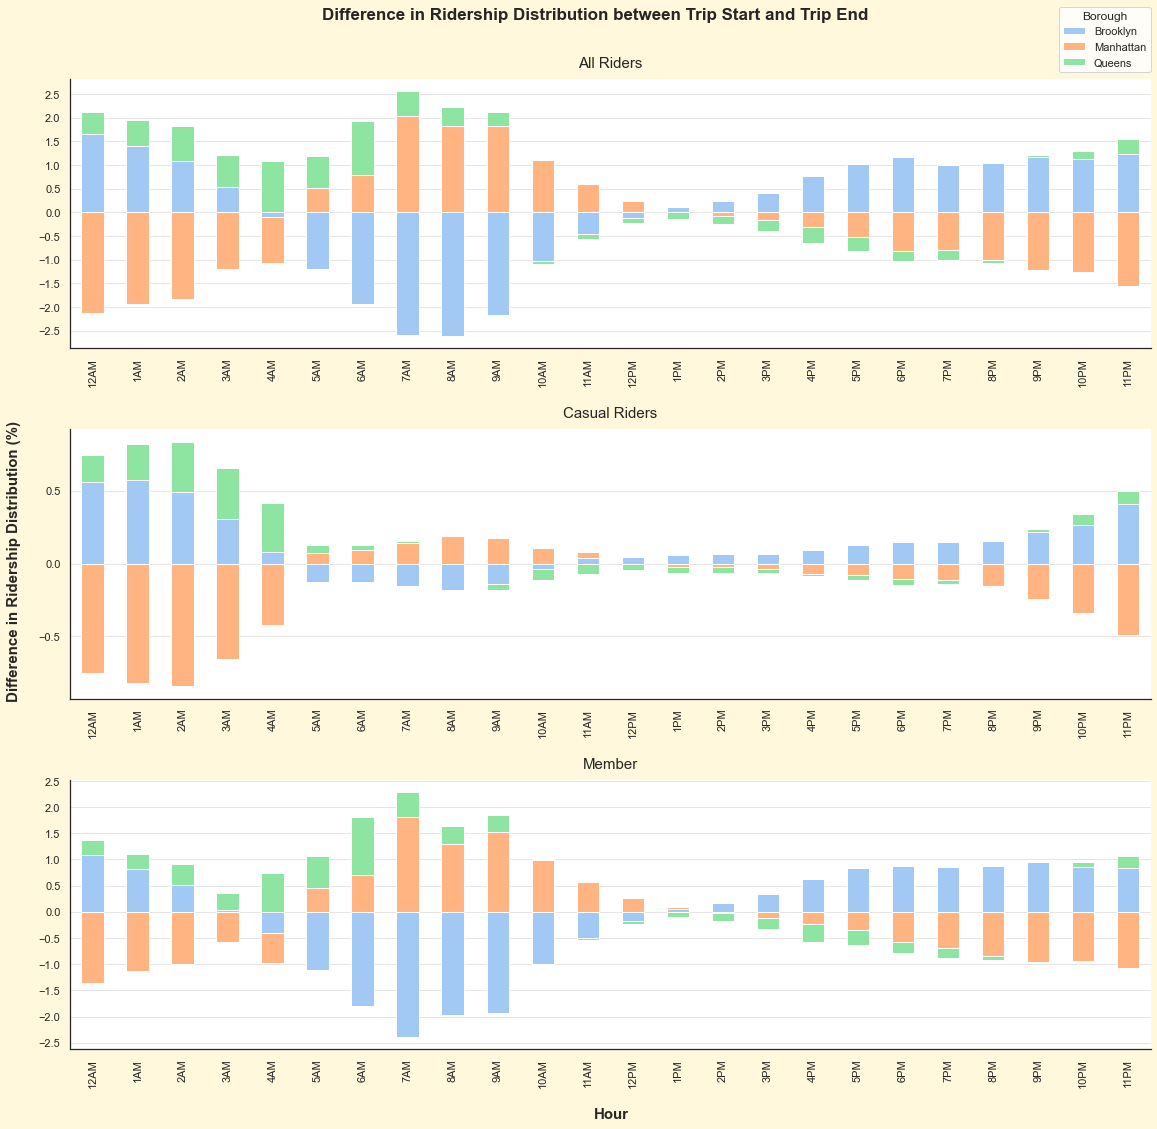

In [26]:
# Set up the figure
fig, ax = plt.subplots(3, figsize=(16,16))

for i, rider_type in enumerate(['all', 'casual', 'member']):
    # Get the difference in ridership distribution
    diff = get_distro_diff(df, rider_type)
    
    # Plot the difference in distribution
    diff.plot(kind='bar', stacked=True, ax=ax[i])
    
    # Add labels
    if i == 2:
        ax[i].set_title(f"{rider_labels[i]}")
    else:
        ax[i].set_title(f"{rider_labels[i]} Riders")

    ax[i].set_xticks(range(24), hours[::-1])
    ax[i].yaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
    ax[i].grid(axis='y', alpha=0.5)
    
    if i == 0:
        ax[i].legend(title='Borough', bbox_to_anchor=[1.005, 1.29])
    else:
        ax[i].legend().remove()

# Add figure-level labels
fig.text(0.499, -0.01, 'Hour', fontsize=15, fontweight='bold')
fig.text(-0.01, 0.355, 'Difference in Ridership Distribution (%)', fontsize=15, fontweight='bold', rotation=90)
fig.suptitle('Difference in Ridership Distribution between Trip Start and Trip End', 
             y=0.955, fontsize=17, fontweight='bold')

# Show the plot
plt.tight_layout(pad=2)
plt.show()

---
## Analyze the impact of temporal factors, such as days of the week and months of the year, on hourly ridership.
---

In [27]:
holiday = df.groupby('isHoliday').sum()[
    [col for col in df.columns if 'trips' in col or 'start' in col and 'end' not in col]]

all_holiday = holiday[[col for col in holiday.columns if 'all' in col]]

all_holiday_pcnt = pd.DataFrame(
    [(all_holiday[col]/all_holiday['nyc_trips_all'])*100 for col in all_holiday.columns[:-1]], 
    index=boroughs).transpose()

In [28]:
no_holiday = pd.DataFrame(index=boroughs)
no_holiday['casual'] = [((holiday[f'{b}_start_casual']/holiday[f'{b}_start_all'])*100)[0] for b in boroughs]
no_holiday['member'] = [((holiday[f'{b}_start_member']/holiday[f'{b}_start_all'])*100)[0] for b in boroughs]

yes_holiday = pd.DataFrame(index=boroughs)
yes_holiday['casual'] = [((holiday[f'{b}_start_casual']/holiday[f'{b}_start_all'])*100)[1] for b in boroughs]
yes_holiday['member'] = [((holiday[f'{b}_start_member']/holiday[f'{b}_start_all'])*100)[1] for b in boroughs]

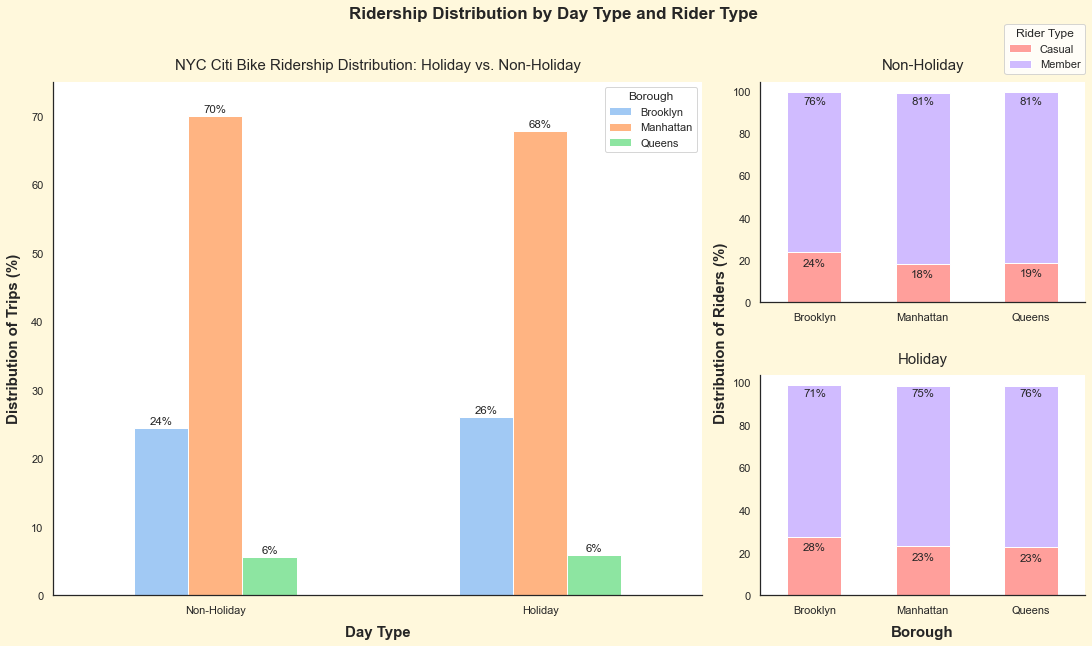

In [29]:
# Create the stacked bar plot with stacked bars for casual and member within each borough
fig = plt.figure(figsize=(16, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])

# Plot for the left subplot spanning two rows
ax1 = plt.subplot(gs[:, 0])
all_holiday_pcnt.plot(kind='bar', ax=ax1)

ax1.set_title('NYC Citi Bike Ridership Distribution: Holiday vs. Non-Holiday')
ax1.set_xticks(range(2), ['Non-Holiday', 'Holiday'], rotation=0)
ax1.set_xlabel('Day Type', fontsize=15, fontweight='bold')
ax1.set_ylabel('Distribution of Trips (%)', fontsize=15, fontweight='bold')
ax1.set_ylim(0, 75)
ax1.legend(labels=borough_labels, title='Borough')
label_bars(ax1, 1)

# Plot for the upper right subplot
ax2 = plt.subplot(gs[0, 1])
no_holiday.plot(kind='bar', stacked=True, color=colors[3:5], ax=ax2)

ax2.set_title('Non-Holiday')
ax2.set_xticks(range(3), borough_labels, rotation=0)
ax2.legend(labels=rider_labels[1:], title=rider_title, bbox_to_anchor=[0.735, 1.01])
label_bars(ax2, -5, stacked=True)

# Plot for the lower right subplot
ax3 = plt.subplot(gs[1, 1])
yes_holiday.plot(kind='bar', stacked=True, color=colors[3:5], ax=ax3)

ax3.set_title('Holiday')
ax3.set_xticks(range(3), borough_labels, rotation=0)
ax3.set_xlabel('Borough', fontsize=15, fontweight='bold')
ax3.legend().remove()
label_bars(ax3, -5, stacked=True)

# Set the labels and title for the entire figure
fig.suptitle('Ridership Distribution by Day Type and Rider Type', y=0.92, fontsize=17, fontweight='bold')
fig.text(0.64, 0.345, 'Distribution of Riders (%)', fontsize=15, fontweight='bold', rotation=90)
# Show the plot
plt.tight_layout(pad=3)
plt.show()

---
## Examine the effects of the pandemic control variable on ridership trends.
---

In [30]:
labels_and_titles = {
    'hour': ['Hourly', 'Hour', range(24), hours[::-1]],
    'weekday': ['Week Day', 'Day of Week', range(7), weekdays],
    'day_type': ['Day Type', 'Type of Day', range(2), ['Weekday', 'Weekend']]
}

In [31]:
def get_pp_distro(df, groupby_col):
    """
    Calculate the distribution of NYC trips for different values of a categorical variable
    during different pandemic periods.

    Args:
        df (pd.DataFrame): DataFrame containing relevant data columns.
        groupby_col (str): The name of the categorical variable to group by.

    Returns:
        pd.DataFrame: DataFrame containing the distribution of NYC trips for each value of the categorical variable
                      during different pandemic periods.
    """
    pp_df = df.groupby(['pandemic_period', groupby_col]).sum()[['nyc_trips_all']].reset_index()
    stacked = pp_df.pivot(index=groupby_col, columns='pandemic_period', values='nyc_trips_all')[pandemic_order]
    pp_distro = pd.DataFrame((stacked[col] / sum(stacked[col]) * 100 for col in stacked.columns)).transpose()
    return pp_distro

In [32]:
def get_pp_rider_distro(df, groupby_col):
    """
    Calculate the distribution of NYC trips by rider type (casual and member)
    for different values of a categorical variable during different pandemic periods.

    Args:
        df (pd.DataFrame): DataFrame containing relevant data columns.
        groupby_col (str): The name of the categorical variable to group by.

    Returns:
        pd.DataFrame: DataFrame containing the distribution of NYC trips by rider type
                      for each value of the categorical variable during different pandemic periods.
    """
    pp_rider_distro = df.groupby(['pandemic_period', groupby_col]).sum()[['nyc_trips_casual', 'nyc_trips_member']]
    
    nyc_trips = df.groupby(['pandemic_period', groupby_col]).sum()['nyc_trips_all']
    
    pp_rider_distro = pd.DataFrame(
        [pp_rider_distro[col] / nyc_trips * 100 for col in pp_rider_distro.columns], 
        index=['casual', 'member']).transpose().reset_index()
    
    pp_rider_distro = pp_rider_distro.pivot(index=groupby_col, columns='pandemic_period')
    return pp_rider_distro

In [33]:
def plot_pp_distro(pp_distro, pp_rider_distro, groupby_col):
    """
    Create a plot displaying the distribution of NYC Citi Bike ridership during different pandemic periods
    based on a specified categorical variable.

    Args:
        pp_distro (pd.DataFrame): DataFrame containing the distribution of NYC trips by pandemic period and the 
                                  categorical variable.
        pp_rider_distro (pd.DataFrame): DataFrame containing the distribution of NYC trips by rider type and 
                                        pandemic period.
        groupby_col (str): The name of the categorical variable used for grouping.

    Returns:
        None: Displays the plot.
    """
    # Set up the figure
    fig, ax = plt.subplots(2, 1, figsize=(16, 12))

    # Gather the labels and titles
    title, xlabel, xrange, xticks = labels_and_titles.get(groupby_col)
    
    # Gather the rider data
    casual = pp_rider_distro['casual'][pandemic_order]
    member = pp_rider_distro['member'][pandemic_order]
    
    # Plot the ridership distribution and rider data by pandemic period
    ax1 = pp_distro.plot(marker='o', ax=ax[0])
    ax2 = casual.plot(marker='o', linestyle='--', color=colors, ax=ax[1])
    ax3 = member.plot(marker='o', color=colors, ax=ax[1])
    
    # Add labels
    ax1.set_title(f'NYC Citi Bike Ridership Distribution: {title} by Pandemic Period', fontsize=17, fontweight='bold')
    ax1.set_xlabel(None)
    ax1.legend(labels=[col.title() for col in pp_distro.columns], title='Pandemic Period')
    ax1.set_xticks(xrange, xticks)
    ax1.grid(alpha=0.25)

    # Show the legend for casual riders
    h1 = mlines.Line2D([], [], linestyle='dashed', color='black', label='Casual')
    h2 = mlines.Line2D([], [], linestyle='solid', color='black', label='Member')
    ax2.legend(handles=[h1, h2], title='Rider Type')
    ax2.grid(alpha=0.25)

    # Add labels and add title for casual riders
    ax2.set_xticks(xrange, xticks)
    ax2.set_yticks(range(0, 101, 10))
    ax2.set_xlabel(None)
    ax2.set_title(f'NYC Citi Bike Ridership Distribution: {title} by Pandemic Period and Rider Type', 
                  fontsize=17, fontweight='bold')
    
    # Add figure-level labels
    fig.text(0.49, -0.01, xlabel, fontsize=15, fontweight='bold')
    fig.text(-0.01, 0.425, 'Distribution of Trips (%)', fontsize=15, fontweight='bold', rotation=90)
    
    # Show the plot
    plt.tight_layout(pad=2.5)
    plt.show()

In [34]:
def explore_pp_distro(df, groupby_col):
    """
    Explore and visualize the distribution of NYC Citi Bike ridership during different pandemic periods
    based on a specified categorical variable.

    This function calculates the distribution of trips and ridership by pandemic period and the specified
    categorical variable, and then creates a plot to visualize the distribution trends.

    Args:
        df (pd.DataFrame): DataFrame containing NYC Citi Bike trip data with pandemic period and categorical variable.
        groupby_col (str): The name of the categorical variable used for grouping.

    Returns:
        tuple: A tuple containing DataFrames representing the distribution of trips and ridership by pandemic period 
               and rider type.
    """
    pp_distro = get_pp_distro(df, groupby_col)
    pp_rider_distro = get_pp_rider_distro(df, groupby_col)
    plot_pp_distro(pp_distro, pp_rider_distro, groupby_col)
    return pp_distro, pp_rider_distro

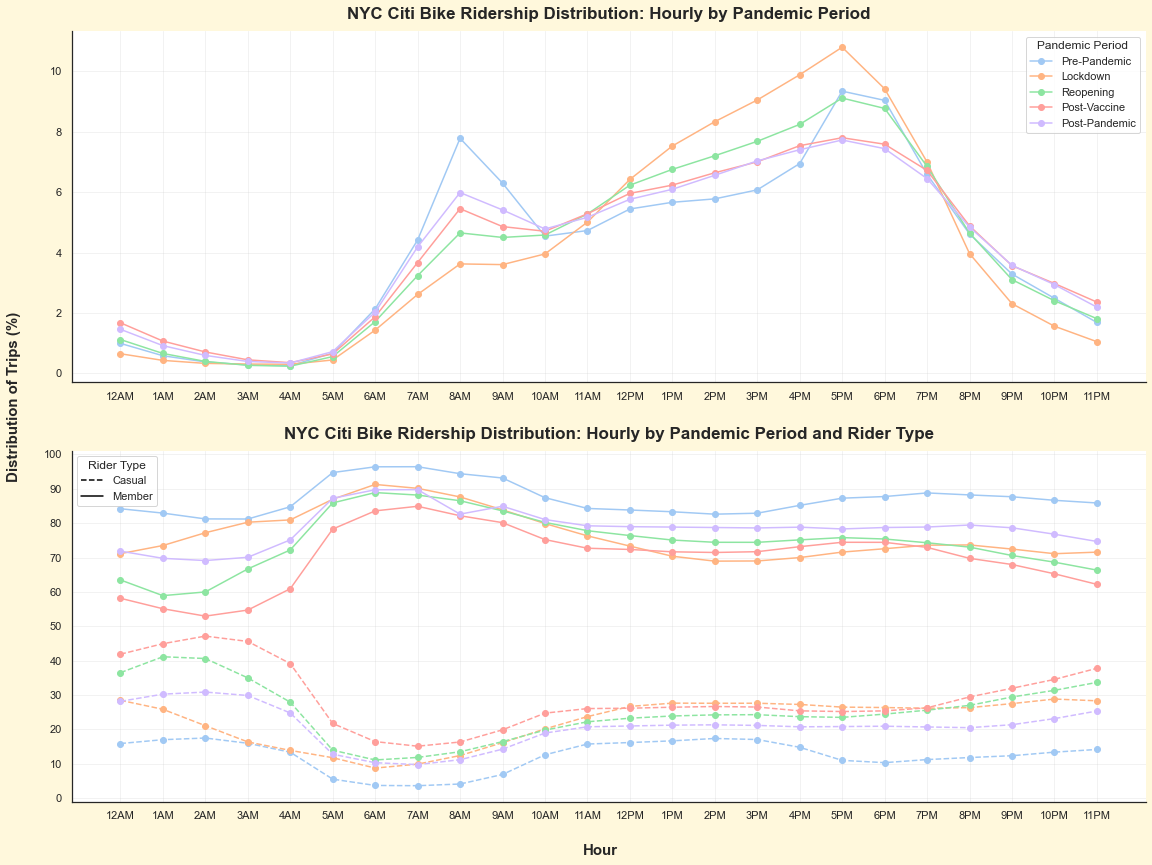

In [35]:
pp_hourly, pp_rider_hourly = explore_pp_distro(df, 'hour')

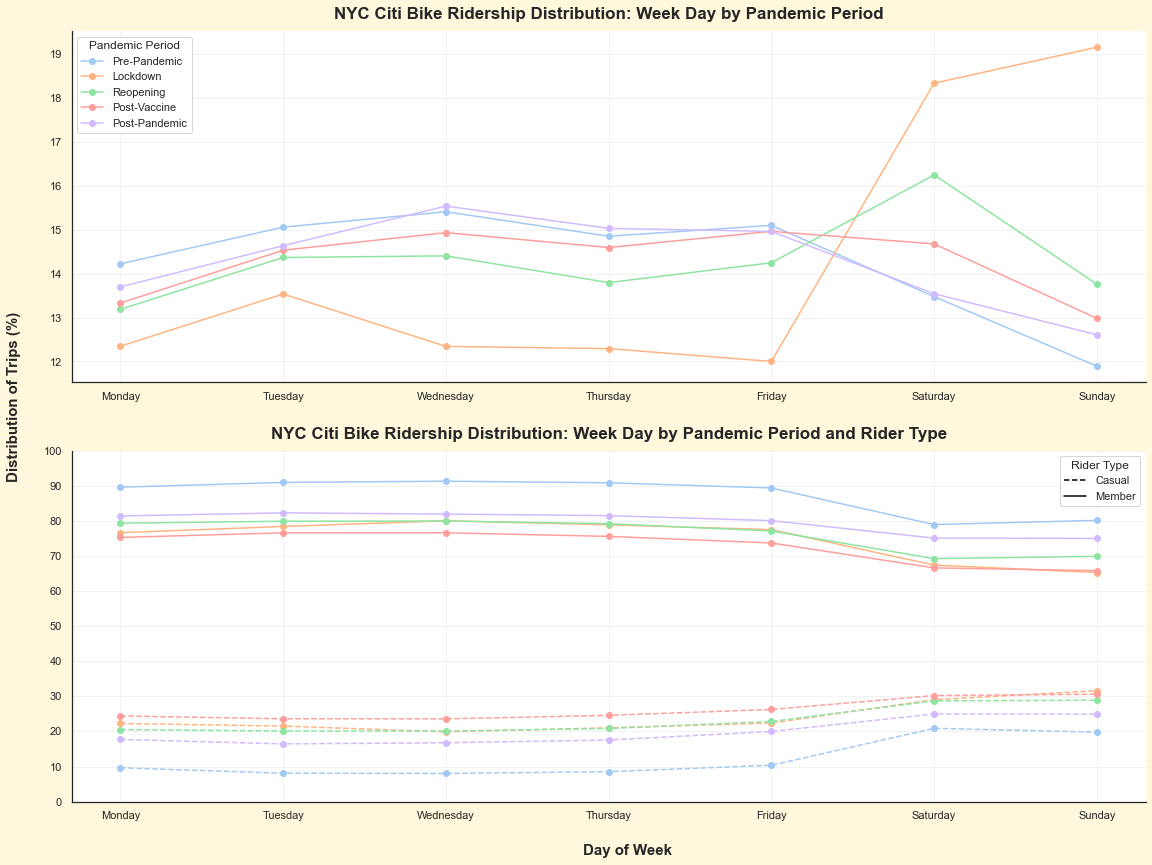

In [36]:
pp_weekday, pp_rider_weekday = explore_pp_distro(df, 'weekday')

---
## Evaluate descriptive statistics and distributions of variables.
---

In [37]:
df.describe().round(2)

nyc_trips_casual  nyc_trips_member  brooklyn_start_all  \
count          43824.00          43824.00            43824.00   
mean             409.50           1666.02              511.17   
std              471.81           1423.28              460.27   
min                8.00             60.00               17.00   
25%               58.00            376.00              113.00   
50%              212.00           1350.00              382.00   
75%              595.00           2613.00              803.00   
max             1668.00           4776.85             1578.00   

       manhattan_start_all  queens_start_all  brooklyn_end_all  \
count             43824.00          43824.00          43824.00   
mean               1459.52            116.50            512.08   
std                1281.62            110.05            464.77   
min                  52.00              3.00             17.00   
25%                 327.00             25.00            114.00   
50%                1137.00             81.00            378.00   
75%                2266.00            179.00            793.25   
max                4349.00            374.00           1603.00   

       manhattan_end_all  queens_end_all  nyc_trips_all  \
count           43824.00        43824.00       43824.00   
mean             1459.32          116.17        2088.87   
std              1282.39          107.58        1841.62   
min                52.00            3.00          74.00   
25%               322.00           26.00         467.00   
50%              1134.00           81.00        1609.00   
75%              2268.00          179.00        3256.00   
max              4336.00          367.00        6250.85   

       brooklyn_start_casual  ...  visibility  isPaidTimeOff  isHoliday  \
count               43824.00  ...    43824.00       43824.00   43824.00   
mean                  121.56  ...        9.52           0.03       0.03   
std                   141.17  ...        1.13           0.16       0.17   
min                     2.00  ...        5.40           0.00       0.00   
25%                    16.00  ...        9.90           0.00       0.00   
50%                    62.00  ...        9.90           0.00       0.00   
75%                   178.00  ...        9.90           0.00       0.00   
max                   498.00  ...        9.90           1.00       1.00   

       nyc_bike_counts      hour  weekday     month      year   weekend  \
count         43824.00  43824.00  43824.0  43824.00  43824.00  43824.00   
mean           1528.84     11.50      3.0      6.52   2020.41      0.29   
std            1191.39      6.92      2.0      3.45      1.50      0.45   
min              92.00      0.00      0.0      1.00   2018.00      0.00   
25%             460.75      5.75      1.0      4.00   2019.00      0.00   
50%            1296.00     11.50      3.0      7.00   2020.00      0.00   
75%            2357.25     17.25      5.0     10.00   2022.00      1.00   
max            4085.00     23.00      6.0     12.00   2023.00      1.00   

       bike_counts_log  
count         43824.00  
mean              2.98  
std               0.49  
min               1.96  
25%               2.66  
50%               3.11  
75%               3.37  
max               3.61  

[8 rows x 35 columns]

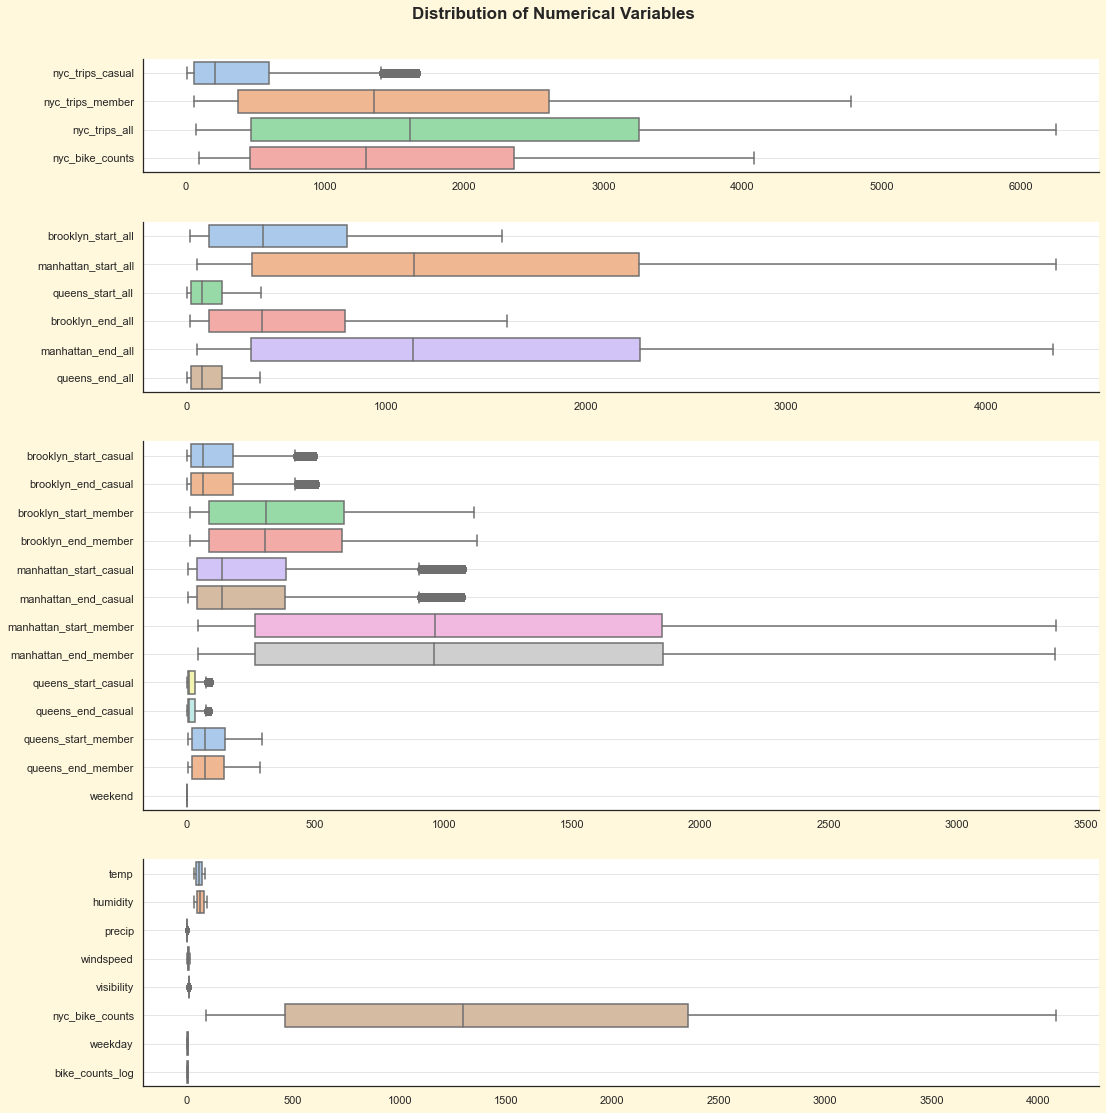

In [50]:
# Create the stacked bar plot with stacked bars for casual and member within each borough
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1.5, 3.25, 2])

# Plot for the first subplot
ax1 = plt.subplot(gs[0])
sns.boxplot(data=df[[col for col in df.columns if 'nyc' in col]], orient='h', ax=ax1)
ax1.grid(axis='y', alpha=0.5)

# Plot for the second subplot
ax2 = plt.subplot(gs[1])
sns.boxplot(
    data=df[[col for col in df.columns if ('start' in col or 'end' in col) and 'all' in col]], orient='h', ax=ax2)
ax2.grid(axis='y', alpha=0.5)

# Plot for the third subplot
ax3 = plt.subplot(gs[2])
sns.boxplot(data=df[[col for col in df.columns if ('start' in col or 'end' in col) and 'all' not in col]], 
            palette=colors, orient='h', ax=ax3)
ax3.grid(axis='y', alpha=0.5)

# Plot for the fourth subplot
ax4 = plt.subplot(gs[3])
sns.boxplot(data=df[[col for col in df.columns if 
                     'start' not in col and 'end' not in col and 'trips' not in col and 
                     col not in ['isPaidTimeOff', 'isHoliday', 'hour', 'month', 'year']]], orient='h', ax=ax4)
ax4.grid(axis='y', alpha=0.5)

# Set the labels and title for the entire figure
fig.suptitle('Distribution of Numerical Variables', fontsize=17, fontweight='bold')

# Show the plot
plt.tight_layout(pad=3)
plt.show()

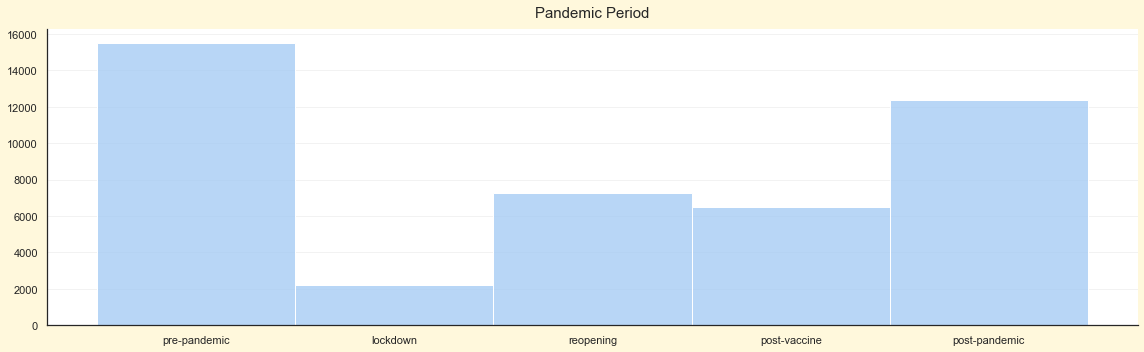

In [39]:
sns.histplot(df['pandemic_period'])

plt.xlabel(None)
plt.ylabel(None)
plt.title('Pandemic Period')
plt.grid(axis='y', alpha=0.25)

fig.text(0.497, -0.02, 'Values', fontsize=15, fontweight='bold')
fig.text(-0.02, 0.44, 'Frequency', fontsize=15, fontweight='bold', rotation=90)
fig.suptitle('Frequency Counts of Categorical Variables', y=1, fontsize=17, fontweight='bold')

plt.tight_layout()
plt.show()

In [40]:
# Calculate the frequency percentage for categorical variables
for col in ['pandemic_period', 'hour_type']:
    print(df[col].value_counts() / len(df) * 100, '\n')

pre-pandemic     35.325392
post-pandemic    28.256207
reopening        16.538883
post-vaccine     14.788700
lockdown          5.090818
Name: pandemic_period, dtype: float64 

not rush hour    79.17123
rush hour        20.82877
Name: hour_type, dtype: float64 



In [41]:
cols = [col.replace('_all', '') for col in df.columns if 'all' in col]
nyc = pd.DataFrame(df[[col + '_all' for col in cols]].sum(), columns=['all'])
casual = pd.DataFrame(df[[col + '_casual' for col in cols]].sum(), columns=['casual'])
member = pd.DataFrame(df[[col + '_member' for col in cols]].sum(), columns=['member'])

In [42]:
pcnt = pd.DataFrame(casual.values / nyc.values * 100, columns=['casual'], 
                    index=casual.index.str.replace('_casual', ''))
pcnt['member'] = member.values / nyc.values * 100

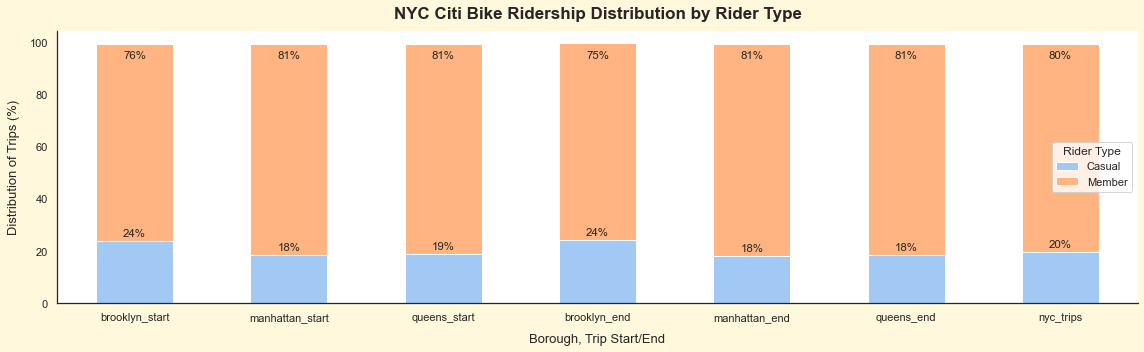

In [43]:
ax = pcnt.plot(kind='bar', stacked=True)
ax.set_xticks(range(len(pcnt)), pcnt.index, rotation=0)
label_bars(ax, 3, stacked=True)
ax.legend(labels=rider_labels[1:], title='Rider Type', loc='center right')
ax.set_title('NYC Citi Bike Ridership Distribution by Rider Type', fontsize=17, fontweight='bold')
ax.set_xlabel('Borough, Trip Start/End')
ax.set_ylabel('Distribution of Trips (%)')
plt.tight_layout()
plt.show()

In [44]:
pcnt

casual     member
brooklyn_start   23.780598  75.666849
manhattan_start  18.205119  81.021898
queens_start     18.629228  80.805201
brooklyn_end     24.038155  75.435164
manhattan_end    18.125716  81.087740
queens_end       18.432235  80.714231
nyc_trips        19.603749  79.756962

In [45]:
cols = [col for col in df.columns if df[col].dtype != object]
results = pd.DataFrame(columns=[
    'variable', 'statistic', 'p_value', 'deviation', 'distribution', 
    'skewness', 'skewness_descript', 'kurtosis', 'kurtosis_descript'
])

# Conduct the Shapiro-Wilk test
for col in cols:
    statistic, p_value = shapiro(df[col])
    
    if statistic > 0.75 and p_value > 0.05:
        deviation = 'deviates'
        distro = 'normal'
    elif statistic > 0.75 and p_value <= 0.05:
        deviation = 'deviates'
        distro = 'non-normal'
    elif statistic <= 0.75 and p_value > 0.05:
        deviation = 'follows'
        distro = 'normal/non-normal'
    elif statistic <= 0.75 and p_value <= 0.05:
        deviation = 'follows'
        distro = 'non-normal'
    
    # Calculate skewness
    data_skewness = skew(df[col])
    
    if data_skewness >= 0:
        skewness_descript = 'right-skewed'
    else:
        skewness_descript = 'left_skewed'

    # Calculate kurtosis
    data_kurtosis = kurtosis(df[col])
    
    if data_kurtosis >= 0:
        kurtosis_descript = 'heavy tail, sharp peak'
    else:
        kurtosis_descript = 'light tail, flat peak'
    
    # Add the test results to the results DataFrame
    results.loc[len(results)] = [
        col, statistic, p_value, deviation, distro, data_skewness, skewness_descript, data_kurtosis, kurtosis_descript
    ]

In [46]:
results

variable  statistic  p_value deviation distribution  \
0         nyc_trips_casual   0.789467      0.0  deviates   non-normal   
1         nyc_trips_member   0.900191      0.0  deviates   non-normal   
2       brooklyn_start_all   0.883243      0.0  deviates   non-normal   
3      manhattan_start_all   0.891031      0.0  deviates   non-normal   
4         queens_start_all   0.865288      0.0  deviates   non-normal   
5         brooklyn_end_all   0.879830      0.0  deviates   non-normal   
6        manhattan_end_all   0.890907      0.0  deviates   non-normal   
7           queens_end_all   0.871399      0.0  deviates   non-normal   
8            nyc_trips_all   0.889428      0.0  deviates   non-normal   
9    brooklyn_start_casual   0.789485      0.0  deviates   non-normal   
10     brooklyn_end_casual   0.786271      0.0  deviates   non-normal   
11   brooklyn_start_member   0.897867      0.0  deviates   non-normal   
12     brooklyn_end_member   0.896782      0.0  deviates   non-normal   
13  manhattan_start_casual   0.789566      0.0  deviates   non-normal   
14    manhattan_end_casual   0.790325      0.0  deviates   non-normal   
15  manhattan_start_member   0.900563      0.0  deviates   non-normal   
16    manhattan_end_member   0.900113      0.0  deviates   non-normal   
17     queens_start_casual   0.770133      0.0  deviates   non-normal   
18       queens_end_casual   0.779335      0.0  deviates   non-normal   
19     queens_start_member   0.878105      0.0  deviates   non-normal   
20       queens_end_member   0.883637      0.0  deviates   non-normal   
21                    temp   0.947441      0.0  deviates   non-normal   
22                humidity   0.956275      0.0  deviates   non-normal   
23                  precip   0.317793      0.0   follows   non-normal   
24               windspeed   0.963970      0.0  deviates   non-normal   
25              visibility   0.375428      0.0   follows   non-normal   
26           isPaidTimeOff   0.140882      0.0   follows   non-normal   
27               isHoliday   0.163497      0.0   follows   non-normal   
28         nyc_bike_counts   0.917880      0.0  deviates   non-normal   
29                    hour   0.950850      0.0  deviates   non-normal   
30                 weekday   0.917807      0.0  deviates   non-normal   
31                   month   0.941383      0.0  deviates   non-normal   
32                    year   0.786246      0.0  deviates   non-normal   
33                 weekend   0.566380      0.0   follows   non-normal   
34         bike_counts_log   0.913548      0.0  deviates   non-normal   

    skewness skewness_descript   kurtosis       kurtosis_descript  
0   1.401862      right-skewed   0.951222  heavy tail, sharp peak  
1   0.717762      right-skewed  -0.577075   light tail, flat peak  
2   0.880451      right-skewed  -0.267430   light tail, flat peak  
3   0.810103      right-skewed  -0.407629   light tail, flat peak  
4   0.977695      right-skewed  -0.129429   light tail, flat peak  
5   0.917254      right-skewed  -0.180637   light tail, flat peak  
6   0.801567      right-skewed  -0.433065   light tail, flat peak  
7   0.952363      right-skewed  -0.167673   light tail, flat peak  
8   0.821594      right-skewed  -0.391379   light tail, flat peak  
9   1.397390      right-skewed   0.940613  heavy tail, sharp peak  
10  1.414628      right-skewed   0.989454  heavy tail, sharp peak  
11  0.731806      right-skewed  -0.569698   light tail, flat peak  
12  0.759890      right-skewed  -0.504132   light tail, flat peak  
13  1.402032      right-skewed   0.949857  heavy tail, sharp peak  
14  1.398919      right-skewed   0.943176  heavy tail, sharp peak  
15  0.713371      right-skewed  -0.582602   light tail, flat peak  
16  0.707753      right-skewed  -0.601191   light tail, flat peak  
17  1.509358      right-skewed   1.301593  heavy tail, sharp peak  
18  1.458732      right-skewed   1.133742  heavy tail, sharp peak  
19  0.902515      right-skewe

**Shapiro-Wilk Test**:
- If statistic > 0.75 and p_value > 0.05: The variable deviates from normality but follows a normal distribution.
- If statistic > 0.75 and p_value <= 0.05: The variable deviates from normality and does not follow a normal distribution.
- If statistic <= 0.75 and p_value > 0.05: The variable follows normality but may or may not follow a normal distribution.
- If statistic <= 0.75 and p_value <= 0.05: The variable does not deviate from normality and does not follow a normal distribution.

>The Shapiro-Wilk test results indicate a departure from normality for most variables, however, due to the p-values of the variables that follow normality it can be determined they they have an abnormal distribution. It can be concluded that none of the variables follow a normal distribution, and this conclusion is reliable given the substantial sample size of 43,829 observations.

**Skewness**:
- If skewness > 0: The variable has a longer right tail, indicating that the distribution is skewed towards higher values.
- If skewness < 0: The variable has a longer left tail, indicating that the distribution is skewed towards lower values.

>The variables related to casual ridership in Brooklyn, Manhattan, and Queens have positive skewness, suggesting that these distributions are skewed towards higher ridership counts. On the other hand, variables related to member ridership in the same boroughs have negative skewness, indicating that these distributions are skewed towards lower ridership counts.

**Kurtosis**:
- If kurtosis > 0: The variable has heavier tails and a sharper peak compared to a normal distribution.
- If kurtosis < 0: The variable has lighter tails and a flatter peak compared to a normal distribution.

>Variables like "precip" and "snow" have significantly positive kurtosis values, suggesting that the distribution of precipitation and snowfall is more peaked and has heavier tails compared to a normal distribution. Conversely, variables like "hour" and "month" have negative kurtosis values, indicating that the distributions of these variables have lighter tails and a flatter peak compared to a normal distribution.

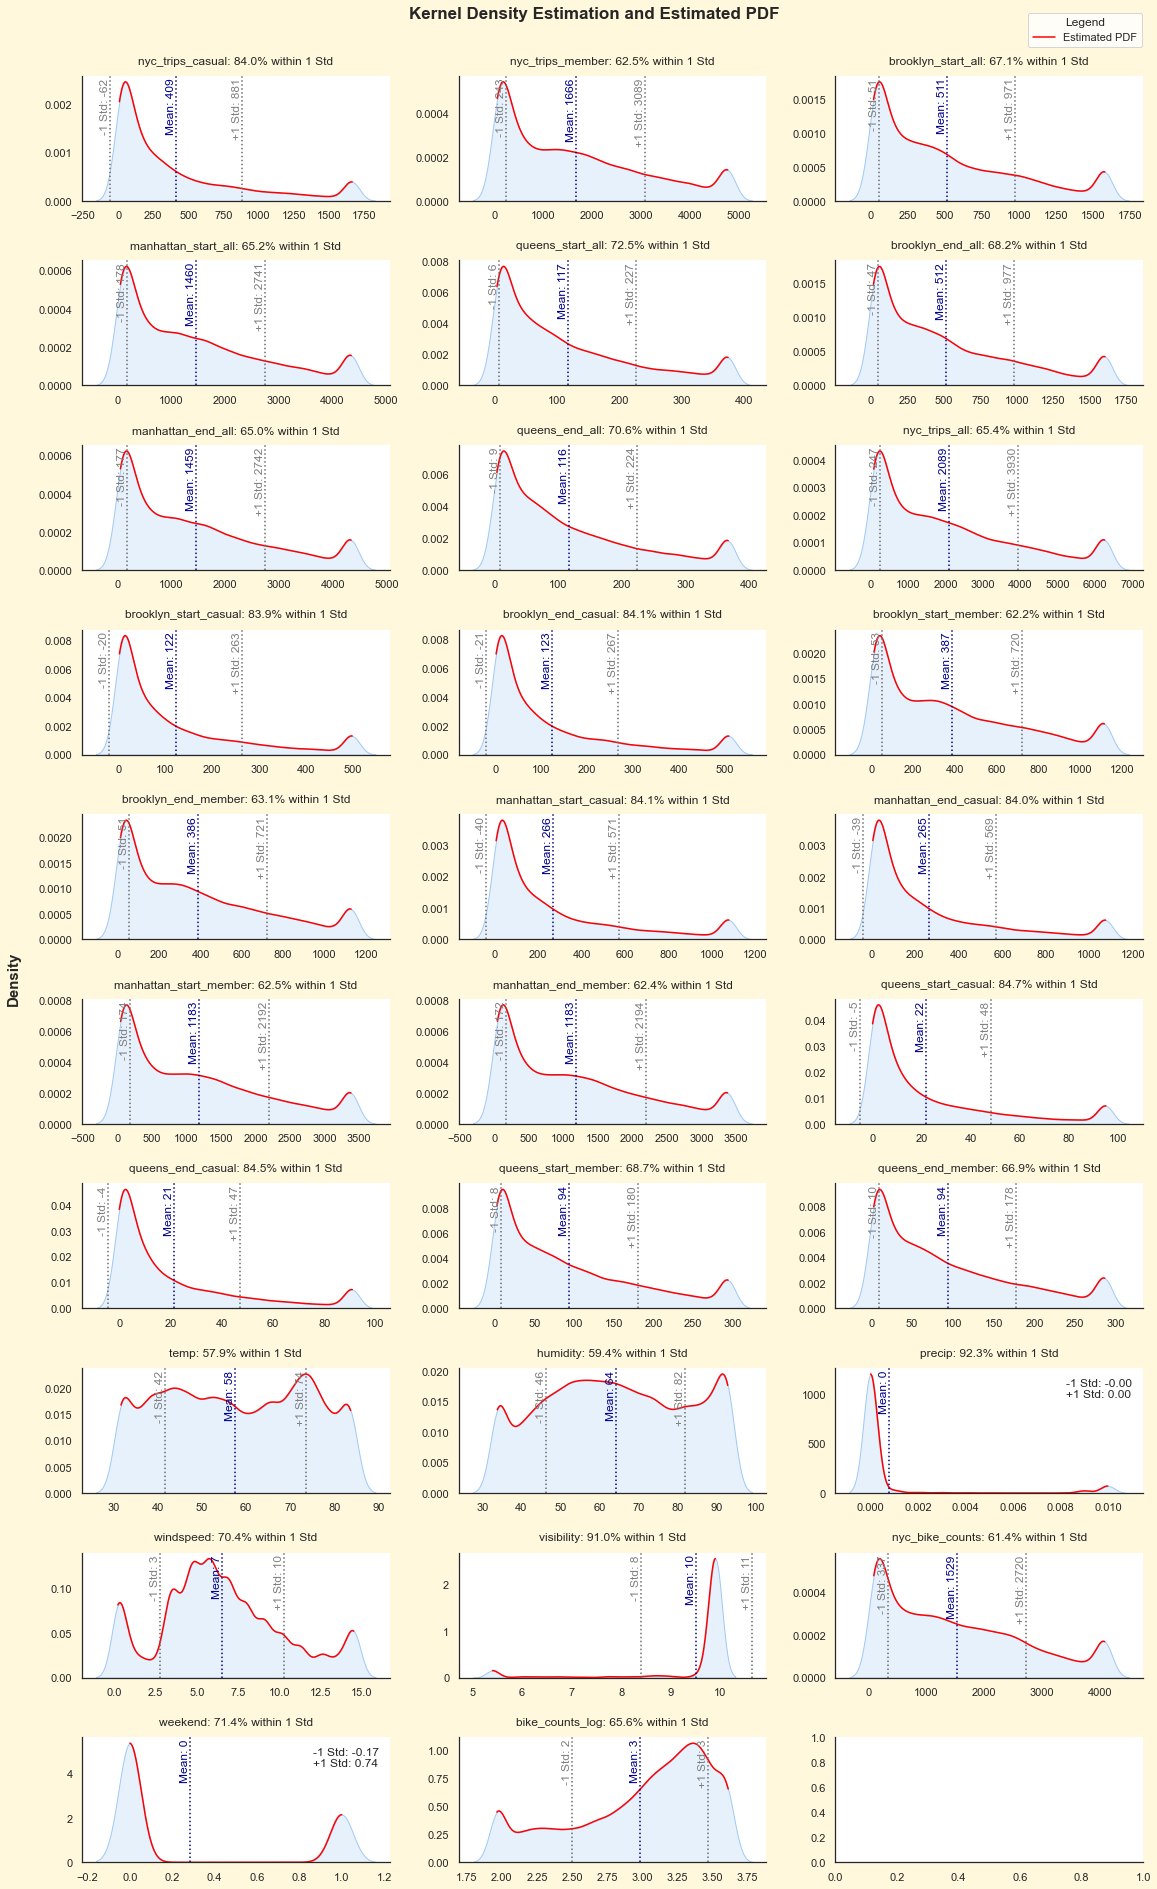

In [47]:
exclusions = ['isPaidTimeOff', 'isHoliday', 'hour', 'weekday', 'month', 'year']

fig, ax = plt.subplots(10, 3, figsize=(16, 27))

for i, col in enumerate([col for col in cols if col not in exclusions]):
    ax_row, ax_col = divmod(i, 3)
    
    # Generate the KDE plot
    sns.kdeplot(data=df[col], shade=True, ax=ax[ax_row, ax_col])

    # Get the kernel density estimation
    kde = gaussian_kde(df[col])

    # Generate the x-values for the PDF estimation
    x = np.linspace(df[col].min(), df[col].max(), 1000)

    # Estimate the PDF using the kernel density estimation
    pdf = kde.evaluate(x)

    # Plot the estimated PDF
    pd.DataFrame([x, pdf], index=['x', 'pdf']).transpose().plot(
        x='x', y='pdf', color='red', label='Estimated PDF', ax=ax[ax_row, ax_col])
    
    # Find the range, mean, and standard deviation
    max_x = max(x)
    max_y = max(pdf)
    mean_x = df[col].mean()
    std = df[col].std()
    
    # Calculate the +1 and -1 std from mean values
    lower_std = mean_x - std
    upper_std = mean_x + std

    # Calculate the count of data falling within one std from the mean
    within_one_std = len(df[(df[col] > lower_std) & (df[col] < upper_std)])

    # Calculate the percent of the data falling within one std from the mean
    pcnt_data = within_one_std / len(df) * 100
    
    # Add the plot title
    ax[ax_row, ax_col].set_title(f'{col}: {pcnt_data:.1f}% within 1 Std', fontsize=12)
    
    # Add a vertical line at the mean x-value
    ax[ax_row, ax_col].axvline(x=mean_x, color='navy', linestyle=':')
    
    # Add a label for the vertical line
    ax[ax_row, ax_col].text(mean_x, max_y, f'Mean: {mean_x:.0f}', color='darkblue', 
                            ha='right', va='center_baseline', rotation=90, fontsize=12)
    
    if round(mean_x) != 0:
        # Add a vertical line at -1 and +1 standard deviation
        ax[ax_row, ax_col].axvline(x=mean_x - std, color='dimgray', linestyle=':')
        ax[ax_row, ax_col].axvline(x=mean_x + std, color='dimgray', linestyle=':')

        # Add a label for the vertical lines
        ax[ax_row, ax_col].text(mean_x - std, max_y, f'-1 Std: {mean_x - std:.0f}', 
                                color='grey', ha='right', va='center_baseline', rotation=90, fontsize=12)
        
        ax[ax_row, ax_col].text(mean_x + std, max_y, f'+1 Std: {mean_x + std:.0f}', 
                                color='grey', ha='right', va='center_baseline', rotation=90, fontsize=12)
    else:        
        # Set the vertical offset value
        y_offset = max_y * 0.1
        
        # Add standard deviation text
        ax[ax_row, ax_col].text(0.75, 0.75, f'-1 Std: {mean_x - std:.2f}\n+1 Std: {mean_x + std:.2f}', 
                                transform=ax[ax_row, ax_col].transAxes, ha='left', va='bottom', fontsize=12)

    # Set plot labels and legend
    ax[ax_row, ax_col].set_xlabel(None)
    ax[ax_row, ax_col].set_ylabel(None)
    if col == cols[2]:
        ax[ax_row, ax_col].legend(title='Legend', bbox_to_anchor=[1.014, 1.55])
    else:
        ax[ax_row, ax_col].legend().remove()
    
# Display the plot
fig.suptitle('Kernel Density Estimation and Estimated PDF', y=0.975, size=17, weight='bold')
fig.text(-0.01, 0.463, 'Density', size=15, weight='bold', rotation=90)
plt.tight_layout(pad=2)
plt.show()